# Data Visualization and Data Distributions
This notebook uses a jackknifed dataset to observe annual and seasonal differences in model parameters.

In [72]:
# Import relevant packages.
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np

In [2]:
# Read in the data... (previously jackknifed so that we have an approx equal number of sharks present vs
# sharks absent)
dat = pd.read_csv('D:/Documents/SpringBoard/capstone-1/datasets/final_files/combined/filled/jackknifed.csv', 
                  dtype={'Zone':'int64', 'Transmitter':'category', 
                         'animal_weight':'float64','animal_length_total':'float64', 
                         'gender':'category', 'location':'category', 'year':'category',
                         'Receiver_D':'float64', 'Lat':'float64', 'Lng':'float64', 
                         'DepthGradient':'float64', 'TempC':'float64', 'Sal':'float64',
                         'ChlA':'float64', 'MoonPhase':'category'}, 
                 parse_dates = ['Date'])

In [3]:
# Shmuel suggested we focus first on just the number of sharks detected in each zone
# each day. 

# So this takes a little bit of extra work
dat_sharks = dat[dat['Transmitter'] != 'NoSharks'] # keep only data where sharks are present
counts = dat_sharks[['Date','Zone','Transmitter']].groupby(['Zone','Date']).agg('count').reset_index()
    # and count the number of transmitters in each zone on each date
environ = dat_sharks[['Date', 'Zone', 'Receiver_D', 'Lat', 'Lng', 'DepthGradient', 'TempC', 
                      'Sal', 'ChlA', 'MoonPhase']]
    # grab the corresponding environmental data
environ = environ.drop_duplicates(subset=['Date','Zone']) # remove duplicates that were 
    # present because more than one shark was heard in a zone in a day
counts = counts.merge(environ) # now merge the environmental data back to the shark counts

# Now, take out the data with sharks from the main dataset, and replace it with the count data
dat = dat[dat['Transmitter'] == 'NoSharks'] # only keep data without sharks
dat = dat[['Zone', 'Date', 'Transmitter', 'Receiver_D', 'Lat', 'Lng', 'DepthGradient', 'TempC', 
           'Sal', 'ChlA', 'MoonPhase']]
    # only keep the relevant columns
dat = dat.append(counts) # and append the count data to this new dataframe

dat = dat.sort_values(['Date','Zone']) # finally, sort the data so that it's in sequential order

# Finally, let's add year and month to the dataset too. 
dat['Month'] = dat['Date'].dt.month
dat['Year'] = dat['Date'].dt.year

## We need to look at the overall distributions of all the parameters, in order to see if there are any outliers and to get an idea of what the data actually look like.

### Let's start with the number of non-zero shark data points per year.

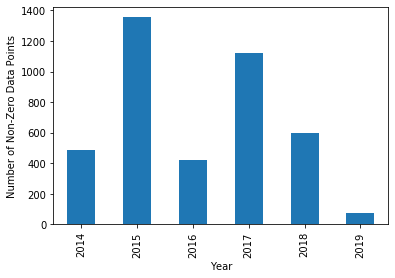

In [41]:
peryear = dat.loc[dat['Transmitter'] > 0, ['Transmitter','Year']].groupby('Year').agg('count')
    # count the number of transmitters > 0 each year
peryear.plot(kind='bar', legend=False) # plot it
plt.ylabel('Number of Non-Zero Data Points') # fix ylabel
plt.show() # show plot

In [115]:
# Now let's look into the actual values
print('Non-Zero Data Points')
print(peryear) # this prints out the number of sharks > 0 per year

print('Zero Data Points')
print(dat.loc[dat['Transmitter'] == 0, ['Transmitter','Year']].groupby('Year').agg('count'))
    # this prints out the number of 0 values per year
    # This one is quite a bit larger than the previous output because the 0s
    # were gathered to match the shark individual data (not the shark count data)

Non-Zero Data Points
      Transmitter
Year             
2014          484
2015         1355
2016          423
2017         1124
2018          596
2019           77
Zero Data Points
      Transmitter
Year             
2014         6040
2015        31213
2016         4903
2017        10442
2018         7348
2019          810


Ok, so it seems like there's more data for years 2015 and 2017 and fewer data for 2019 (understandable because the year isn't over yet). 

# Now let's move on to the number of sharks detected over the entire dataset.

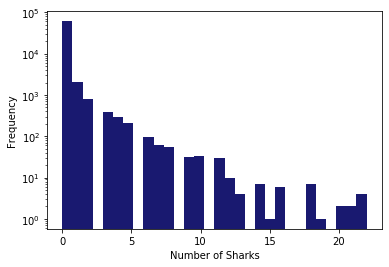

In [25]:
dat['Transmitter'] = pd.to_numeric(dat['Transmitter'], errors='coerce').fillna(0)
    # first, let's make sure that the transmitter column is a number, and 'NoSharks' == 0

# Plotting time.
dat['Transmitter'].plot(kind='hist', logy=True, bins=30, color='midnightblue') # let's do a histogram
plt.xlabel('Number of Sharks') # with a nice x label
plt.show() # show plot

In [5]:
print(dat['Transmitter'].describe())

count    64815.000000
mean         0.155211
std          0.858960
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         22.000000
Name: Transmitter, dtype: float64


It seems like most of the time 0 sharks are present. This is understandable, considering the amount of space and time that are covered by this dataset. However, on one day, 22 total sharks were present in a single zone -- that's a lot of sharks! I don't think that we should remove data where we get a large number of sharks, because maybe there is some environmental parameter that could explain this phenomenon.

Let's see how this changes over the course of the dataset. I have plotted a time series below.

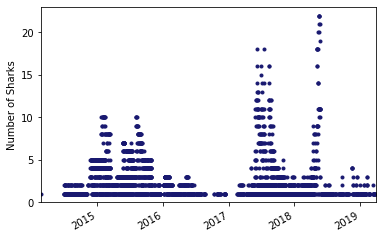

In [6]:
dat[dat['Transmitter'] > 0].plot(x='Date', y='Transmitter', style='.', color='midnightblue', legend=False)
    # let's plot date vs the number of sharks as little dots on the graph and let's just
    # ignore 0 values
plt.ylabel('Number of Sharks') # update the ylabel
plt.xlabel('') # update the xlabel
plt.show() # and show the plot

There seems to me some sort of seasonal/annual cycle here, where sharks are present at 'high' numbers for some part of the year, but are absent at others. This really started happening in about 2015 and had the highest peak during 2017 and 2018. However, the problem with this figure is that we can't really see how many dots fall into each category. Let's try re-plotting this as a series of boxplots and let's do one boxplot every quarter (3 months).

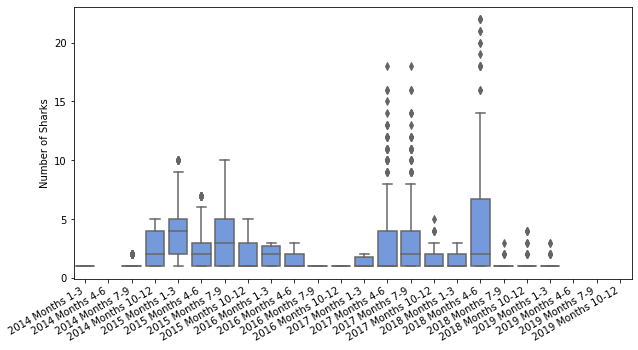

In [18]:
month_groups = {1: '1-3', 2: '1-3', 3: '1-3', 4: '4-6', 5: '4-6', 6: '4-6', 7: '7-9', 8: '7-9', 9: '7-9',
                10: '10-12', 11: '10-12', 12: '10-12'} # create a dictionary to pass the categorized 
                # months to the dataset

dat['month_groups'] = dat['Month'].map(month_groups) # add month groups
dat['month_groups'] = dat['Year'].astype(str)+ ' Months '+ dat['month_groups'].astype(str)
    # add year groups

columns_my_order = ['2014 Months 1-3', '2014 Months 4-6', '2014 Months 7-9', '2014 Months 10-12',
                    '2015 Months 1-3', '2015 Months 4-6', '2015 Months 7-9', '2015 Months 10-12',
                    '2016 Months 1-3', '2016 Months 4-6', '2016 Months 7-9', '2016 Months 10-12',
                    '2017 Months 1-3', '2017 Months 4-6', '2017 Months 7-9', '2017 Months 10-12',
                    '2018 Months 1-3', '2018 Months 4-6', '2018 Months 7-9', '2018 Months 10-12', 
                    '2019 Months 1-3', '2019 Months 4-6', '2019 Months 7-9', '2019 Months 10-12']
    # order the categories so it displays sequentially

# Start plotting
plt.figure(figsize=(10,5)) # set plot size so we can see all labels nicely
sharkbox = sns.boxplot(x='month_groups', y='Transmitter', data=dat[dat['Transmitter']>0], order=columns_my_order, 
                      color='cornflowerblue')
    # plot only data that are >0 and in the order we specify
sharkbox = sharkbox.set_xticklabels(sharkbox.get_xticklabels(), rotation=30, horizontalalignment = 'right')
    # fix the xlabels so that they're easier to read
sharkbox = plt.xlabel('') # remove the xlabel
sharkbox = plt.ylabel('Number of Sharks') # clean up the ylabel
plt.show() # show the plot

Here, we see that the peaks we see before sometimes change the distribution of data for those months, but are primarily due to values that are outside of the IQR. 

Perhaps this has something to do with environmental conditions, but it might also have to do with the number of receivers that are in the water listeing for tagged animals. Let's look into that next.

### Next up: The number of receivers deployed per zone per day.

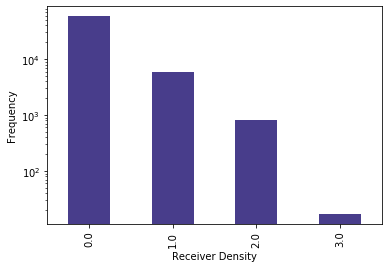

In [103]:
# Since we have discrete values, let's use a barplot
r_counts = pd.DataFrame(dat['Receiver_D'].value_counts()).reset_index()
    # get value counts for each receiver density and reset the index
r_counts.columns = ['Receiver_D', 'Frequency'] # rename the columns
r_counts.plot.bar(x='Receiver_D', y='Frequency', logy=True, color='darkslateblue', legend=False)
    # plot on the logy scale
plt.xlabel('Receiver Density') # label the x
plt.ylabel('Frequency') # label the y
plt.show() # show the plot

In [37]:
print(dat['Receiver_D'].describe())

count    64815.000000
mean         0.115961
std          0.360226
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: Receiver_D, dtype: float64


For most of the data, there are 0 receivers deployed in a zone in a day. This matches the histogram for the shark detection data; you can't detect sharks if the detection device isn't in the water! Let's see if the time series plot for receiver density matches the time series plot for the number of sharks detected. 

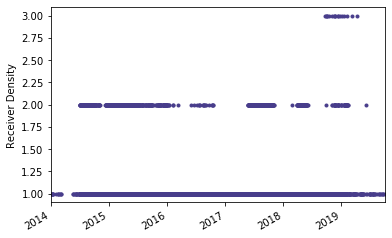

In [38]:
dat[dat['Receiver_D'] > 0].plot(x='Date', y='Receiver_D', style='.', color='darkslateblue', legend=False)
    # let's plot date vs the number of receivers as little dots on the graph and let's just
    # ignore 0 values
plt.ylabel('Receiver Density') # update the ylabel
plt.xlabel('') # update the xlabel
plt.show() # and show the plot

Looking at this, it seems like most of the time at least one receiver was in the water, so maybe shark presents isn't directly associated with receiver density, but other environmental conditions.

Let's re-draw this graph but looking at the total number of receivers deployed per day (adding up receivers in each zone).

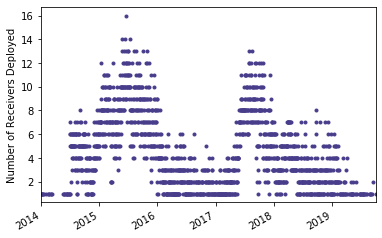

In [53]:
receivers = dat[['Date', 'Receiver_D']].groupby('Date').agg('sum')
receivers[receivers['Receiver_D'] > 0].plot(style='.', color='darkslateblue', legend=False)
    # let's plot date vs the number of receivers as little dots on the graph and let's just
    # ignore 0 values
plt.ylabel('Number of Receivers Deployed') # update the ylabel
plt.xlabel('') # update the xlabel
plt.show() # and show the plot

This is a lot more useful, but I think we can do better. Let's look at how this changes every quarter. 

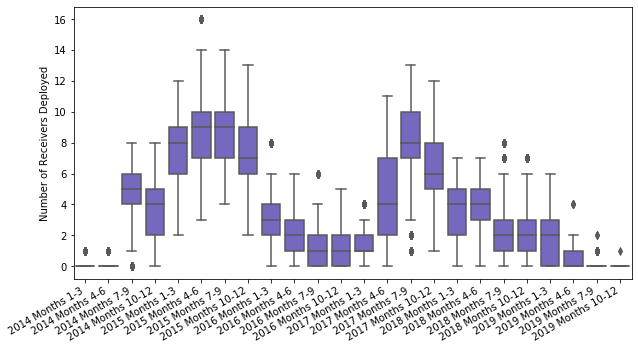

In [55]:
# Start plotting
receivers = dat[['Date', 'Receiver_D']].groupby('Date').agg('sum').reset_index()
receivers = pd.merge(receivers, dat[['Date', 'month_groups']], how='left')

plt.figure(figsize=(10,5)) # set plot size so we can see all labels nicely
r_box = sns.boxplot(x='month_groups', y='Receiver_D', data=receivers, order=columns_my_order, 
                      color='slateblue')
    # plot only data that are >0 and in the order we specify
r_box = r_box.set_xticklabels(r_box.get_xticklabels(), rotation=30, horizontalalignment = 'right')
    # fix the xlabels so that they're easier to read
r_box = plt.xlabel('') # remove the xlabel
r_box = plt.ylabel('Number of Receivers Deployed') # clean up the ylabel
plt.show() # show the plot

It seems like there are peaks in the number of receivers deployed, and these peaks might match up with the number of sharks detected. However, it's not a perfect relationship, because the peaks aren't exactly the same. I think environmental conditions also play a role.

### Let's move on to seafloor depth gradient.

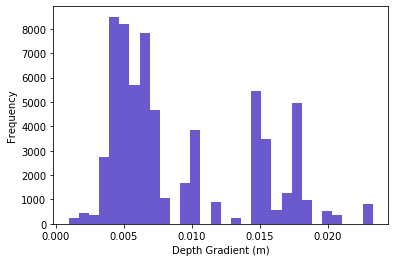

In [56]:
dat['DepthGradient'].plot(kind='hist', bins=30, color='slateblue')
    # let's plot this in 30 bins 
plt.xlabel('Depth Gradient (m)') # add the xlabel
plt.show() # and show the plot

In [59]:
print(dat['DepthGradient'].describe())

count    64815.000000
mean         0.009139
std          0.005172
min          0.000931
25%          0.004998
50%          0.006744
75%          0.014539
max          0.023329
Name: DepthGradient, dtype: float64


I don't really see a common distribution in these data. All changes in depth are small (less than 1 meter), so it might be too small of a difference to actually change the probability of shark presence. We'll see how the model responds to these data.

### Let's move on to temperature data. 

In [ ]:
dat['TempC'].plot(kind='hist', bins=30, color='cornflowerblue') # let's do another
    # histogram for temperature
plt.xlabel('Temperature (Degree Celcius)') # fix the xlabel
plt.show() # and show the plot

In [60]:
print(dat['TempC'].describe())

count    64815.000000
mean        18.386278
std          2.660196
min         10.994000
25%         16.294000
50%         17.876000
75%         20.701000
max         25.021000
Name: TempC, dtype: float64


This is a bimodal distribution, which is likely explained by different seasons having different water temperatures (warmer in summer and cooler in winter). Overall, temperatures are about 17-18 degrees Celcius between 2014 and 2019. 

Let's look at the time series data in the next plot.

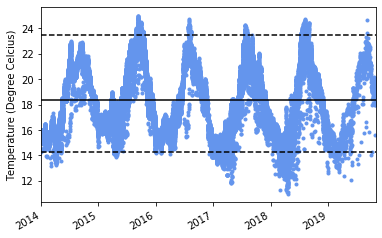

In [80]:
dat.plot(x='Date',y='TempC', style='.', color='cornflowerblue', legend=False)
    # plot the time series data
plt.axhline(np.percentile(dat['TempC'], [2.5]), color='black', linestyle='dashed')
plt.axhline(np.percentile(dat['TempC'], [97.5]), color='black', linestyle='dashed')
plt.axhline(np.mean(dat['TempC']), color='black')
plt.ylabel('Temperature (Degree Celcius)') # fix the ylabel
plt.xlabel('') # fix the xlabel
plt.show() # show the plot

This graph definitely explains the bimodal distribution we saw above. During the winter (the beginnig of the year), temperatures drop. It does seem like temperatures are hitting lower temperatures in more recent years (2017-2019) compared to before 2017. This might explain why the peaks in the previous graph were not the same height. Maybe this larger temperature gradient could explain the higher number of observed sharks in 2017 and 2018. 

### The next thing we should check out is the salinity values.

In [ ]:
dat['Sal'].plot(kind='hist', bins=30, color='lightblue') # plot a histogram of salinity values
plt.xlabel('Salinity (PSU)') # add xlabel
plt.show() # show the plot

In [62]:
print(dat['Sal'].describe())

count    64815.000000
mean        33.288114
std          1.339602
min         30.002523
25%         32.443480
50%         33.274063
75%         34.052225
max         39.441444
Name: Sal, dtype: float64


Salinity appears to be a slightly skewed normal distribution with most data around 33 PSU. We may want to consider removing super salty (> 34 PSU, greater than the third quartile of data) conditions from the dataset, since it might have to do with environmental anomalies. However, I think we should first look and see how the model reacts to the high salinity values. Perhaps this occurs at times where sharks are definitely <i>not</i> around? It might be a strong driving force for these animals.

Let's see if there's an obvious annual/seasonal relationship for salinity.

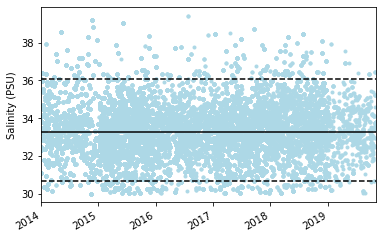

In [81]:
dat.plot(x='Date',y='Sal', style='.', color='lightblue', legend=False)
    # a nice little dot graph for the salinity data
plt.axhline(np.percentile(dat['Sal'], [2.5]), color='black', linestyle='dashed')
plt.axhline(np.percentile(dat['Sal'], [97.5]), color='black', linestyle='dashed')
plt.axhline(np.mean(dat['Sal']), color='black')
plt.ylabel('Salinity (PSU)') # label the y axis
plt.xlabel('') # label the x axis
plt.show() # show the plot

There doesn't seem to be an obvious cycle for when Salinity values are super high, so it might just be part of a normal change that affects nearshore waters from time to time.

### Let's move on to Chlorophyll-A.

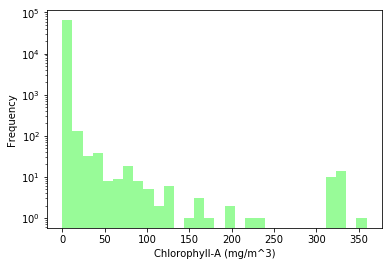

In [66]:
dat['ChlA'].plot(kind='hist', bins=30, color='palegreen', logy=True) # let's plot a histogram for these data
plt.xlabel('Chlorophyll-A (mg/m^3)') # update the xlabel
plt.show() # and show the plot.

In [67]:
print(dat['ChlA'].describe())

count    6.481500e+04
mean     8.508174e-01
std      7.383422e+00
min      2.268702e-13
25%      1.768914e-01
50%      3.171089e-01
75%      5.774195e-01
max      3.592543e+02
Name: ChlA, dtype: float64


Most chlorophyll levels are small (< 1), but there's one really high value of 360. I think this might be a bad value, so we definitely should take it out of the dataset prior to running our models.

Let's see if we can pinpoint dates when these values are high.

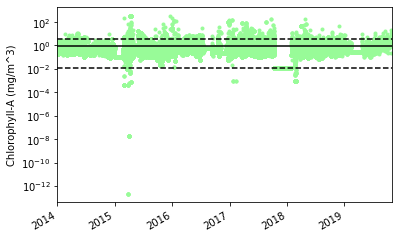

In [83]:
dat.plot(x='Date',y='ChlA', style='.', color='palegreen', logy=True, legend=False)
    # build a time series plot
plt.axhline(np.percentile(dat['ChlA'], [2.5]), color='black', linestyle='dashed')
plt.axhline(np.percentile(dat['ChlA'], [97.5]), color='black', linestyle='dashed')
plt.axhline(np.mean(dat['ChlA']), color='black')
plt.ylabel('Chlorophyll-A (mg/m^3)') # add ylabel
plt.xlabel('') # add xlabel
plt.show() # show the plot

It seems like there's an annual peak in Chlorophyll-A from 2015-2019. It might indicate a harmful algal bloom, or it might indicate an instrument error in the measurement itself. We also see that there are actually quite a few points over 50 mg/m^3... We should look into historical accounts of harmful algal blooms and keep data that correspond to those time periods, but remove data that show high Chlorophyll levels and are not backed up by historical reports. 

### Finally, moon phase. 
Most categorical data in my original dataset corresponded to individual sharks (things like sex, tagging location, tagging cohort). Most of those data were lost when I took overall counts of sharks in each zone. However, I can add this back in later if I want to make my model answer more specific questions.

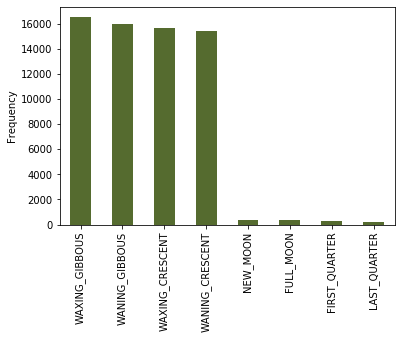

In [69]:
dat['MoonPhase'].value_counts().plot(kind='bar', color='darkolivegreen')
    # let's get the number of values in each moon phase category and plot them
plt.ylabel('Frequency') # add the ylabel
plt.show() # and show the plot

In [70]:
print(dat['MoonPhase'].value_counts()) # let's print out the value data

WAXING_GIBBOUS     16525
WANING_GIBBOUS     15974
WAXING_CRESCENT    15670
WANING_CRESCENT    15445
NEW_MOON             390
FULL_MOON            369
FIRST_QUARTER        259
LAST_QUARTER         183
Name: MoonPhase, dtype: int64


First quarter, last quarter, new moon, and full moon occur on much fewer days than the waxing and waning moon phases. I think we might want to consider only using data with waxing/waning lunar phases so that the sample sizes are approximately the same. But, 200-300 points is still a lot, so let's leave it in for now and see what the analyses tell us.